# Testing Predictions Pepper Buetepage

0 1 0.0
0 2 0.0
1 2 4.75472482423455e-47
0 1 0.0
0 2 0.0
1 2 6.658407486043964e-217
0 1 0.0
0 2 0.0
1 2 1.0961959565641119e-24


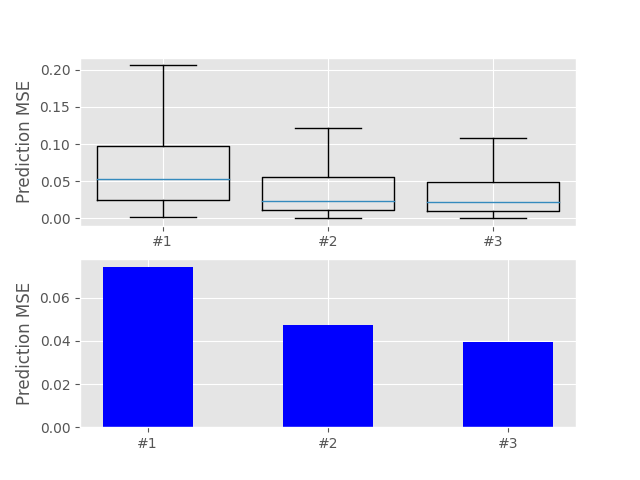

In [9]:
%matplotlib widget
import numpy as np
import scipy
import matplotlib.pyplot as plt
from test import evaluate_ckpt

fig = plt.figure()
plt.title('MSE of predicted robot joints after observing human')
ax_box_pred = plt.subplot(2,1,1)
# ax_box_vae = plt.subplot(2,2,2)
ax_bar_pred = plt.subplot(2,1,2)
# ax_bar_vae = plt.subplot(2,2,4)
k = 0

pred_mse = []
# vae_mse = []

for model_type, use_cov in [
                        ('vae_vanilla', False),#, 'final.pth'),
                        # ('vae_vanilla_hsmm', False),#, 'final.pth'),
                        # ('vae_crossrecon_samplenocovcond', False),#, 'final.pth'),
                        # ('vae_crossrecon_samplecovcond', True),#, 'final.pth'),
                        ('vae_crossrecon_nocovcondsampling', False),#, 'final.pth'),
                        ('vae_crossrecon_covcondsampling', True),#, 'final.pth'),
                        # ('vae_crossrecon_nocovcond', False),#, 'final.pth'),
                        # ('vae_crossrecon_covcond', True),#, 'final.pth'),
                        # ('mild_vanilla', False),#, 'final.pth'),
                        # # ('mild_vanilla_hsmm', False),#, 'final.pth'),
                        # ('mild_crossrecon_samplenocovcond', False),#, 'final_250.pth'),
                        # ('mild_crossrecon_samplecovcond', True),#, 'final.pth'),
                        # ('mild_crossrecon_nocovcondsampling', False),#, 'final.pth'),
                        # ('mild_crossrecon_covcondsampling', True),#, 'final.pth'),
                        # # ('mild_crossrecon_nocovcond', False),#, 'final_250.pth'),
                        # # ('mild_crossrecon_covcond', True),#, 'final.pth'),
                    ]:
    pred_mse.append([])
    for ckpt_name in [
                        'final_100.pth', 
                        # 'final_100_finetuning.pth', 
                        # 'final_199.pth', 
                        # 'final_199_finetuning.pth',
                    ]:
        pred_mse_k = []

        for trial in range(4):
            ckpt_path = f'logs/2023/downsampled/bp_pepper/{model_type}/z5/trial{trial}/models/{ckpt_name}'
            pred_mse_ckpt, _ = evaluate_ckpt(ckpt_path, use_cov)
            pred_mse_k += pred_mse_ckpt
        pred_mse[-1].append(pred_mse_k)
        if ckpt_name[10:] == 'finetuning.pth':
            ckpt_name = 'tuned_'+ckpt_name[6:9]
        # elif ckpt_name == 'final_100.pth':
            # ckpt_name = 'final_100'
        else:
            ckpt_name = ckpt_name[:-4]
        model_name = f'{model_type:<40}' + str(use_cov)[0] + f' {ckpt_name}'
        if ckpt_name=='final_100':
            positions=[k]
        elif ckpt_name=='final_199':
            positions=[k+0.5]
        ax_box_pred.boxplot(pred_mse_k, positions=positions, showfliers=False, widths=[0.8])
        # print(f'{model_name}\t{np.mean(pred_mse):.4e} ± {np.std(pred_mse):.4e} \t{np.mean(vae_mse):.4e} ± {np.std(vae_mse):.4e}')
    k+=1

p_values = np.ones((len(pred_mse), len(pred_mse)))
for i in range(len(pred_mse)-1):
    for j in range(i+1,len(pred_mse)):
        p_values[i,j] = scipy.stats.ttest_ind(pred_mse[i][0], pred_mse[j][0]).pvalue
        print(i,j,p_values[i,j])

p_values = np.ones((len(pred_mse), len(pred_mse)))
for i in range(len(pred_mse)-1):
    for j in range(i+1,len(pred_mse)):
        p_values[i,j] = scipy.stats.ttest_rel(pred_mse[i][0], pred_mse[j][0]).pvalue
        print(i,j,p_values[i,j])

p_values = np.ones((len(pred_mse), len(pred_mse)))
for i in range(len(pred_mse)-1):
    for j in range(i+1,len(pred_mse)):
        p_values[i,j] = scipy.stats.mannwhitneyu(pred_mse[i][0], pred_mse[j][0]).pvalue
        print(i,j,p_values[i,j])


X = np.arange(len(pred_mse))
ax_bar_pred.bar(X, [np.mean(pred_mse[i][0]) for i in range(len(pred_mse))], color = 'b', width = 0.5)#, label='100 epochs')
# ax_bar_pred.bar(X + 0.6, [np.mean(pred_mse[i][1]) for i in range(len(pred_mse))], color = 'm', width = 0.2, label='200 Epochs')
ax_bar_pred.set_ylabel('Prediction MSE')
ax_box_pred.set_ylabel('Prediction MSE')
ax_bar_pred.set_xticks(X, ('#1', '#2', '#3'))
ax_box_pred.set_xticks(X, ('#1', '#2', '#3'))
# ax_bar_pred.legend()


\#1 - Standard Autoencoding Reconstruction

\#2 - Autoencoding Reconstruction + Decoding the robot's actions conditioned on human latent mean

\#3 - Autoencoding Reconstruction + Decoding the robot's actions conditioned on human latent distribution

\#4 - Same as \#2 but using Monte Carlo samples for AE reconstruction and also for conditioning (Sampling from posterior followed by conditioning)